## Load ressources

In [2]:
from tensorflow.keras.models import load_model
import joblib

# Charger le modèle textuel
best_text_model = joblib.load("../model/registry/text_classification_model.pkl")

# Charger le modèle visuel
best_visual_model = load_model("../model/registry/model_eff_transfer.h5")

print("Modèles chargés avec succès.")

Modèles chargés avec succès.


In [3]:
import pandas as pd

train_df = pd.read_csv("../data/image_classification/split_train.csv")
val_df = pd.read_csv("../data/image_classification/split_val.csv")
test_df = pd.read_csv("../data/image_classification/split_test.csv")

train_df.shape, val_df.shape, test_df.shape

((21004, 21), (4501, 21), (4491, 21))

In [4]:
import tensorflow as tf


# Function to load images
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize for model input
    image = image / 255.0  # normalize
    return image


def process_labels(labels):
    return tf.convert_to_tensor(labels, dtype=tf.float32)

In [17]:
import numpy as np

labels_array = np.array(train_df.iloc[:, 3:21].values)

class_counts = labels_array.sum(axis=0)  # Count samples per class
class_weights = {
    i: len(labels_array) / (len(class_counts) * class_counts[i])
    for i in range(len(class_counts))
}


def compute_sample_weights(labels, class_weights):
    return np.array(
        [
            sum(class_weights[i] * label[i] for i in range(len(label)))
            for label in labels
        ]
    )


sample_weights = compute_sample_weights(labels_array, class_weights)

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


def preprocess_text(text):
    # normalisation
    text = text.lower()

    text = re.sub(r"[^a-z\s]", "", text)

    # tokenization
    tokens = word_tokenize(text)

    # suppression des stop words english
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

data = pd.read_csv("../data/image_classification/train.csv", on_bad_lines="skip")
data["Processed_Caption"] = data["Caption"].apply(preprocess_text)

train_df["Processed_Caption"] = train_df["Caption"].apply(preprocess_text)
val_df["Processed_Caption"] = val_df["Caption"].apply(preprocess_text)
test_df["Processed_Caption"] = test_df["Caption"].apply(preprocess_text)

max_sequence_length = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["Processed_Caption"])
word_index = tokenizer.word_index
print(f"Vocabulaire: {len(word_index)} mots uniques")


# Remplaçons la fonction tokenize_text pour la rendre compatible avec tf.data.Dataset
def tokenize_text(text):
    @tf.function(input_signature=[tf.TensorSpec(shape=(), dtype=tf.string)])
    def _tokenize_text_tf(text_tensor):
        # Convertir le tensor en string Python
        text_str = text_tensor.numpy().decode('utf-8')
        # Tokenize avec la fonction Python normale
        sequences = tokenizer.texts_to_sequences([text_str])
        # Convertir en tensor TensorFlow
        return tf.constant(pad_sequences(sequences, maxlen=max_sequence_length, padding="post")[0])
    
    # Cette fonction s'exécutera en mode eager pour chaque élément
    return tf.py_function(
        lambda t: _tokenize_text_tf(t),
        [text],
        tf.int32
    )

Vocabulaire: 6018 mots uniques


In [25]:
# Recuperer les embeddings

glove_file = "../data/glove.6B.300d.txt"

embeddings_index = {}

with open(glove_file, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype="float32")
        embeddings_index[word] = coefs

In [68]:
# Encode the processed captions using the GloVe embeddings
def encode_caption(caption, embeddings_index, embedding_dim=300):
    words = caption.split()
    embedding_matrix = np.zeros((len(words), embedding_dim))
    for i, word in enumerate(words):
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return np.mean(embedding_matrix, axis=0)

## Experimentation 1

In [69]:
def extract_features_in_batches(model, dataset, filename):
    features = []
    labels = []

    # Cas 1: Si c'est un dataset TensorFlow (pour le modèle d'image)
    if isinstance(dataset, tf.data.Dataset):
        for batch in dataset:
            batch_inputs, batch_labels = batch

            if hasattr(model, "predict_proba"):
                batch_features = model.predict_proba(batch_inputs)
            else:
                batch_features = model.predict(batch_inputs)

            # Store features and labels
            features.append(batch_features)
            labels.append(batch_labels.numpy())  # Convert Tensor to NumPy
            
        features = np.concatenate(features, axis=0)
        labels = np.concatenate(labels, axis=0)
    
    # Cas 2: Si c'est un DataFrame pandas (pour le modèle de texte)
    elif isinstance(dataset, pd.DataFrame):
        # Les modèles scikit-learn traitent toutes les données en une fois
        if hasattr(model, "predict_proba"):
            features = model.predict_proba(dataset)
        else:
            features = model.predict(dataset)
        
        # Pour les labels, nous devons les fournir séparément s'ils ne sont pas inclus dans le dataset
        labels = np.zeros((len(dataset), 1))  # Placeholder, à remplacer par les vraies étiquettes si disponibles
    
    # Cas 3: Autres types de données (numpy arrays, listes, etc.)
    else:
        if hasattr(model, "predict_proba"):
            features = model.predict_proba(dataset)
        else:
            features = model.predict(dataset)
        
        # Pour les labels, utiliser un placeholder
        labels = np.zeros((len(features), 1))
    
    # Enregistrement des features et labels
    if filename:
        np.save(f"../model/registry/{filename}_features.npy", features)
        np.save(f"../model/registry/{filename}_labels.npy", labels)
        print(f"Saved: {filename}_features.npy and {filename}_labels.npy")

    return features, labels

In [79]:

AUTOTUNE = tf.data.AUTOTUNE

image_train_ds = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(train_df["ImageURL"]).map(load_image),
            tf.data.Dataset.from_tensor_slices(
                process_labels(train_df.iloc[:, 3:21].values)
            ),  # Assuming labels are in columns 1 to n
        )
    )
    .batch(32)
    .prefetch(AUTOTUNE)
)

image_val_ds = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(val_df["ImageURL"]).map(load_image),
            tf.data.Dataset.from_tensor_slices(
                process_labels(val_df.iloc[:, 3:21].values)
            ),  # Assuming labels are in columns 1 to n
        )
    )
    .batch(32)
    .prefetch(1)
)

image_test_ds = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(test_df["ImageURL"]).map(load_image),
            tf.data.Dataset.from_tensor_slices(
                process_labels(test_df.iloc[:, 3:21].values)
            ),  # Assuming labels are in columns 1 to n
        )
    )
    .batch(32)
    .prefetch(1)
)

text_train_ds = pd.DataFrame(
    [encode_caption(caption, embeddings_index) for caption in train_df["Processed_Caption"].values],
    columns=[f"dim_{i}" for i in range(300)]
)

text_val_ds = pd.DataFrame(
    [encode_caption(caption, embeddings_index) for caption in val_df["Processed_Caption"].values],
    columns=[f"dim_{i}" for i in range(300)]
)

text_test_ds = pd.DataFrame(
	[encode_caption(caption, embeddings_index) for caption in test_df["Processed_Caption"].values],
	columns=[f"dim_{i}" for i in range(300)]
)

In [80]:
## Image
train_pred_features, train_pred_labels = extract_features_in_batches(
    best_visual_model, image_train_ds, "train_image"
)

val_pred_features, val_pred_labels = extract_features_in_batches(
    best_visual_model, image_val_ds, "val_image"
)

test_pred_features, test_pred_labels = extract_features_in_batches(
    best_visual_model, image_test_ds, "test_image"
)


## Text
train_pred_text_features, train_pred_text_labels = extract_features_in_batches(
    best_text_model, text_train_ds, "train_text"
)

val_pred_text_features, val_pred_text_labels = extract_features_in_batches(
    best_text_model, text_val_ds, "val_text"
)   

test_pred_text_features, test_pred_text_labels = extract_features_in_batches(
    best_text_model, text_test_ds, "test_text"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━

In [82]:
text_train_features = np.load("../model/registry/train_text_features.npy")
text_val_features = np.load("../model/registry/val_text_features.npy")
text_test_features = np.load("../model/registry/test_text_features.npy")

image_train_features = np.load("../model/registry/train_image_features.npy")
image_val_features = np.load("../model/registry/val_image_features.npy")
image_test_features = np.load("../model/registry/test_image_features.npy")

y_train = np.load("../model/registry/train_image_labels.npy")
y_val = np.load("../model/registry/val_image_labels.npy")
y_test = np.load("../model/registry/test_image_labels.npy")


In [83]:
fused_features_train = np.concatenate([text_train_features, image_train_features], axis=-1)

fused_features_val = np.concatenate([text_val_features, image_val_features], axis=-1)

fused_features_test = np.concatenate([text_test_features, image_test_features], axis=-1)

In [93]:
# Define generator function for efficient loading
def data_generator(features, labels):
    for x, y in zip(features, labels):
        yield x, y

# Use from_generator to avoid memory overload
train_ds_fusion = tf.data.Dataset.from_generator(
    lambda: data_generator(fused_features_train, y_train),
    output_signature=(
        tf.TensorSpec(shape=(fused_features_train.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(y_train.shape[1],), dtype=tf.float32)
    )
).batch(4)

val_ds_fusion = tf.data.Dataset.from_generator(
    lambda: data_generator(fused_features_val, y_val),
    output_signature=(
        tf.TensorSpec(shape=(fused_features_val.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(y_val.shape[1],), dtype=tf.float32)
    )
).batch(4)

test_ds_fusion = tf.data.Dataset.from_generator(
    lambda: data_generator(fused_features_test, y_test),
    output_signature=(
        tf.TensorSpec(shape=(fused_features_test.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(y_test.shape[1],), dtype=tf.float32)
    )
).batch(4)

In [94]:
train_ds_fusion = train_ds_fusion.prefetch(tf.data.AUTOTUNE)
val_ds_fusion = val_ds_fusion.prefetch(tf.data.AUTOTUNE)
test_ds_fusion = test_ds_fusion.prefetch(tf.data.AUTOTUNE)

In [84]:
print(text_test_features.shape)
print(image_test_features.shape)

(4491, 18)
(4491, 18)


In [91]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

input_fused = Input(shape=(fused_features_train.shape[1],))
x = Dense(64, activation='relu')(input_fused)
x = Dropout(0.3)(x)
output_fused = Dense(18, activation='sigmoid')(x)
fusion_model_1 = Model(inputs=input_fused, outputs=output_fused)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # using small learning rate for overfitting, default one is 0.001
fusion_model_1.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

fusion_model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,538 (13.82 KB)

 Trainable params: 3,538 (13.82 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
fusion_model_1.fit(train_ds_fusion,
                 validation_data=val_ds_fusion,
                 epochs=5)

Epoch 1/5


   5248/Unknown 28s 5ms/step - AUC: 0.7444 - accuracy: 0.5609 - loss: 0.3802

c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5251/5251 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - AUC: 0.7445 - accuracy: 0.5610 - loss: 0.3801 - val_AUC: 0.9142 - val_accuracy: 0.7525 - val_loss: 0.1661
Epoch 2/5
5251/5251 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - AUC: 0.9108 - accuracy: 0.7765 - loss: 0.1604 - val_AUC: 0.9453 - val_accuracy: 0.8152 - val_loss: 0.1338
Epoch 3/5
5251/5251 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - AUC: 0.9402 - accuracy: 0.8206 - loss: 0.1329 - val_AUC: 0.9552 - val_accuracy: 0.8245 - val_loss: 0.1174
Epoch 4/5
5251/5251 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - AUC: 0.9492 - accuracy: 0.8276 - loss: 0.1192 - val_AUC: 0.9593 - val_accuracy: 0.8300 - val_loss: 0.1090
Epoch 5/5
5251/5251 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - AUC: 0.9543 - accuracy: 0.8295 - loss: 0.1115 - val_AUC: 0.9616 - val_accuracy: 0.8287 - val_loss: 0.1043


In [96]:
import matplotlib.pyplot as plt


def plot_training_history(history, model_name="Text Model", metrics=["AUC", "loss"]):
    i = 0
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 5 * len(metrics)))
    fig.suptitle(f"{model_name} Training History", fontsize=16)

    for metric in metrics:
        if metric not in history.history:
            raise ValueError(f"Metric '{metric}' not found in history.")
        axes[i].plot(history.history[metric], label="Train " + metric)
        axes[i].plot(history.history["val_" + metric], label="Val " + metric)
        axes[i].set_title(f"{model_name} {metric}")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel(metric)
        axes[i].legend()

        i += 1

    plt.show()

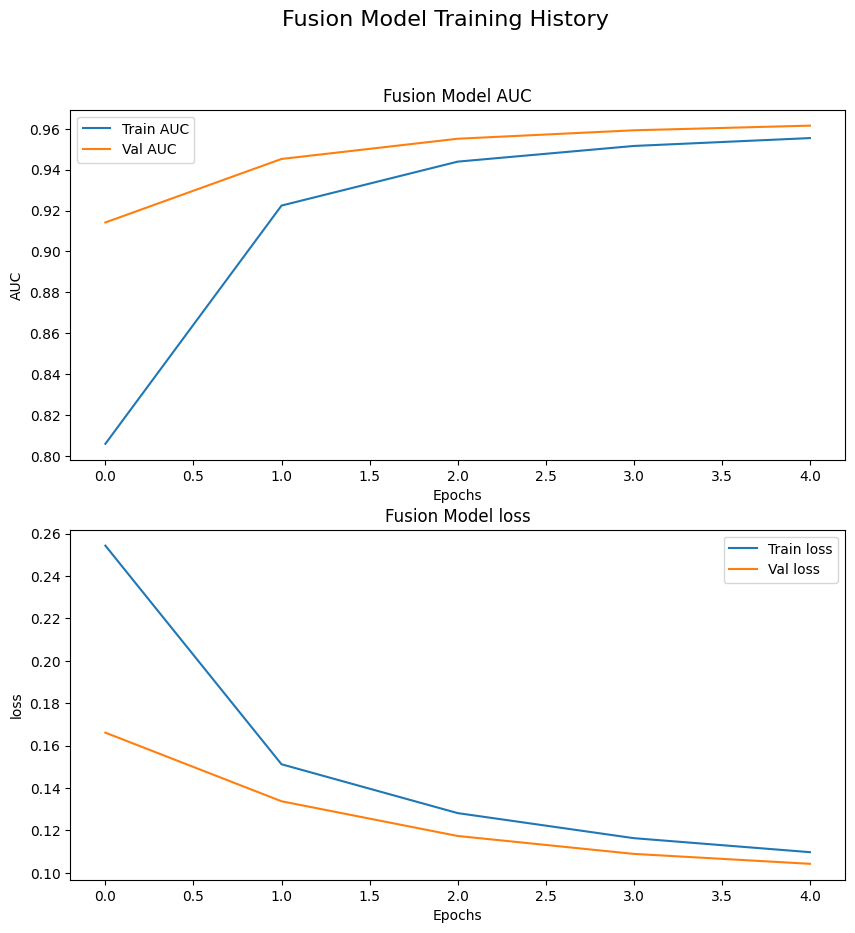

In [97]:
plot_training_history(fusion_model_1.history, model_name="Fusion Model", metrics=["AUC", "loss"])

## Experimentation 2